##import

In [2]:
%tensorflow_version 2.x
from keras.datasets import imdb
from keras.preprocessing import sequence
import keras
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
f = open("473.astar-s0.txt", 'r')

In [5]:
unique_instr_id = list()
cycle_count = list()
load_address = list()
instr_pointer_load = list()
llc_hit_miss = list()

f.seek(0, 0)
while True:
  line = f.readline()
  if not line: break
  split_line = line.split(', ')
  unique_instr_id.append(split_line[0])
  cycle_count.append(split_line[1])
  load_address.append(split_line[2])
  instr_pointer_load.append(split_line[3])
  llc_hit_miss.append(split_line[4][:-1])

for i in range(len(load_address)):
  load_address[i] = int(int(load_address[i], 16)/64)

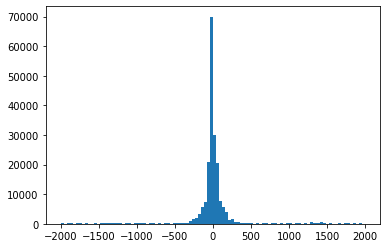

[687, 312, 445, 755, 611, 566, 515, 584, 334, 698, 576, 584, 544, 164, 903, 564, 582, 532, 1000, 0, 969, 436, 1000, 591, 564, 0, 1000, 0, 531, 1000, 586, 532, 510, 586, 0, 1000, 618, 564, 513, 532, 583, 516, 564, 564, 564, 597, 532, 532, 0, 1000, 751, 564, 602, 532, 532, 526, 564, 563, 0, 1000, 564, 602, 532, 532, 404, 622, 564, 0, 1000, 564, 597, 531, 437, 370, 768, 564, 589, 532, 571, 461, 603, 301, 763, 589, 0, 1000, 0, 1000, 1000, 0, 532, 347, 685, 1000, 0, 781, 0, 1000, 563, 501]


In [6]:
delta = list()
for i in range(len(load_address)-1):
  delta.append(load_address[i+1] - load_address[i])

plot_this = list()
for i in range(len(load_address)-1):
  if delta[i] > 2000:
    continue
  if delta[i] < -2000:
    continue
  plot_this.append(delta[i])
plt.hist(plot_this, bins=100)
plt.show()

for i in range(len(delta)):
  if delta[i] > 500:
    delta[i] = 1000
    continue
  if delta[i] < -500:
    delta[i] = 0
    continue
  delta[i] += 500

print(delta[0:100])

In [7]:
seq_length = 10 # length of sequence for a training example
epoch = 10

##make set

In [8]:
examples_per_epoch = len(delta)//(seq_length+1)
dataset = tf.data.Dataset.from_tensor_slices(delta)

In [9]:
sequences = dataset.batch(seq_length+1, drop_remainder=True)

In [10]:
def split_input_target(chunk):  # for the example: 1 2 3 4 5
    input_text = chunk[:-1]  # 1 2 3 4
    target_text = chunk[1:]  # 2 3 4 5
    return input_text, target_text  # 1 2 3 4, 2 3 4 5

dataset = sequences.map(split_input_target)  # we use map to apply the above function to every entry

In [11]:
for x, y in dataset.take(2):
  print("\n\nEXAMPLE\n")
  print("INPUT")
  print(x)
  print("\nOUTPUT")
  print(y)



EXAMPLE

INPUT
tf.Tensor([687 312 445 755 611 566 515 584 334 698], shape=(10,), dtype=int32)

OUTPUT
tf.Tensor([312 445 755 611 566 515 584 334 698 576], shape=(10,), dtype=int32)


EXAMPLE

INPUT
tf.Tensor([ 584  544  164  903  564  582  532 1000    0  969], shape=(10,), dtype=int32)

OUTPUT
tf.Tensor([ 544  164  903  564  582  532 1000    0  969  436], shape=(10,), dtype=int32)


In [12]:
BATCH_SIZE = 64
ADDRESS_PREDICT_SIZE = 1001
EMBEDDING_DIM = 256
RNN_UNITS = 1024

BUFFER_SIZE = 10000

data = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

##make model

In [13]:
def build_model(address_predict_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(address_predict_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(address_predict_size)
  ])
  return model

model = build_model(ADDRESS_PREDICT_SIZE,EMBEDDING_DIM, RNN_UNITS, BATCH_SIZE)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           256256    
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 1001)          1026025   
Total params: 6,529,257
Trainable params: 6,529,257
Non-trainable params: 0
_________________________________________________________________


##Create loss function

In [14]:
for input_example_batch, target_example_batch in data.take(1):
  example_batch_predictions = model(input_example_batch)  # ask our model for a prediction on our first batch of training data (64 entries)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, address_prediect_size)")  # print out the output shape

(64, 10, 1001) # (batch_size, sequence_length, address_prediect_size)


In [15]:
# we can see that the predicition is an array of 64 arrays, one for each entry in the batch
print(len(example_batch_predictions))
print(example_batch_predictions)

64
tf.Tensor(
[[[-2.1475571e-04 -3.1965508e-03 -2.3681654e-03 ... -1.0852481e-03
   -1.0408387e-03 -2.3741175e-03]
  [-6.9697103e-06 -7.2338869e-04 -6.0637097e-04 ... -4.9342453e-03
    1.2342841e-04  1.9204148e-04]
  [ 3.7591555e-05 -4.1760444e-03 -3.1575307e-03 ... -4.3776557e-03
   -1.1686743e-03 -2.0621903e-03]
  ...
  [ 3.1597589e-04 -5.3803646e-03 -4.0877899e-03 ... -7.0034475e-03
   -1.7795295e-03 -2.7945350e-04]
  [ 6.4217125e-04 -3.2829405e-03 -2.2104720e-03 ... -8.7249177e-03
   -8.3681796e-04  1.8987701e-03]
  [ 1.7982729e-04 -1.3348637e-03 -8.0845988e-04 ... -9.9122142e-03
   -1.3918501e-04  3.8463133e-03]]

 [[-2.1475571e-04 -3.1965508e-03 -2.3681654e-03 ... -1.0852481e-03
   -1.0408387e-03 -2.3741175e-03]
  [ 4.7726842e-04 -6.3305441e-03 -4.3776464e-03 ... -1.6427020e-03
   -1.8303167e-03 -4.4383965e-03]
  [ 1.0309824e-03 -3.6701204e-03 -2.1692947e-03 ... -5.1240008e-03
   -4.2986238e-04 -1.5321580e-03]
  ...
  [ 7.6655047e-03 -1.2357674e-02 -5.9587006e-03 ... -3.2960081e

In [16]:
# lets examine one prediction
pred = example_batch_predictions[0]
print(len(pred))
print(pred)
# notice this is a 2d array of length 100, where each interior array is the prediction for the next character at each time step

10
tf.Tensor(
[[-2.1475571e-04 -3.1965508e-03 -2.3681654e-03 ... -1.0852481e-03
  -1.0408387e-03 -2.3741175e-03]
 [-6.9697103e-06 -7.2338869e-04 -6.0637097e-04 ... -4.9342453e-03
   1.2342841e-04  1.9204148e-04]
 [ 3.7591555e-05 -4.1760444e-03 -3.1575307e-03 ... -4.3776557e-03
  -1.1686743e-03 -2.0621903e-03]
 ...
 [ 3.1597589e-04 -5.3803646e-03 -4.0877899e-03 ... -7.0034475e-03
  -1.7795295e-03 -2.7945350e-04]
 [ 6.4217125e-04 -3.2829405e-03 -2.2104720e-03 ... -8.7249177e-03
  -8.3681796e-04  1.8987701e-03]
 [ 1.7982729e-04 -1.3348637e-03 -8.0845988e-04 ... -9.9122142e-03
  -1.3918501e-04  3.8463133e-03]], shape=(10, 1001), dtype=float32)


In [17]:
# and finally well look at a prediction at the first timestep
time_pred = pred[0]
print(len(time_pred))
print(time_pred)
# and of course its 65 values representing the probabillity of each character occuring next

1001
tf.Tensor(
[-0.00021476 -0.00319655 -0.00236817 ... -0.00108525 -0.00104084
 -0.00237412], shape=(1001,), dtype=float32)


In [18]:
# If we want to determine the predicted character we need to sample the output distribution (pick a value based on probabillity)
sampled_indices = tf.random.categorical(pred, num_samples=1)

# now we can reshape that array and convert all the integers to numbers to see the actual characters
sampled_indices = np.reshape(sampled_indices, (1, -1))[0]
predicted = sampled_indices

predicted  # and this is what the model predicted for training sequence 1

array([238, 407, 342, 856, 515,   4, 571, 246, 771,  36])

In [19]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [20]:
model.compile(optimizer='adam', loss=loss)

In [21]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [22]:
history = model.fit(data, epochs=epoch, callbacks=[checkpoint_callback])

Epoch 1/10
1024/1024 [==============================] - 16s 14ms/step - loss: 1.9622
Epoch 2/10
1024/1024 [==============================] - 15s 14ms/step - loss: 1.8705
Epoch 3/10
1024/1024 [==============================] - 15s 14ms/step - loss: 1.8374
Epoch 4/10
1024/1024 [==============================] - 15s 15ms/step - loss: 1.8047
Epoch 5/10
1024/1024 [==============================] - 15s 14ms/step - loss: 1.7771
Epoch 6/10
1024/1024 [==============================] - 15s 15ms/step - loss: 1.7526
Epoch 7/10
1024/1024 [==============================] - 15s 15ms/step - loss: 1.7300
Epoch 8/10
1024/1024 [==============================] - 15s 15ms/step - loss: 1.7085
Epoch 9/10
1024/1024 [==============================] - 15s 15ms/step - loss: 1.6858
Epoch 10/10
1024/1024 [==============================] - 15s 15ms/step - loss: 1.6637


In [23]:
model = build_model(ADDRESS_PREDICT_SIZE, EMBEDDING_DIM, RNN_UNITS, batch_size=1)

In [24]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [25]:
def generate_address(model, start_address):
  # Evaluation step (generating address using the learned model)

  # Number of characters to generate
  num_generate = 2

  input_eval = tf.expand_dims(start_address, 0)

  # Empty string to store our results
  generated = []

  # Low temperatures results in more predictable.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()

  predictions = model(input_eval)

  # remove the batch dimension
  predictions = tf.squeeze(predictions, 0)

  # using a categorical distribution to predict the character returned by the model
  predictions = predictions / temperature

  predictions_np = predictions.numpy()

  # using probability
  '''
  generated = tf.random.categorical(predictions_np, num_samples=num_generate)[-1,0].numpy()  
  '''

  # using argmax
  for i in range(num_generate):
    predicted_id = tf.argmax(predictions_np[seq_length-1])
    for j in range(seq_length):
      predictions_np[j][predicted_id] = 0
    generated.append((int)(predicted_id))

  return generated

In [26]:
inp = [687, 312, 445, 755, 611, 566, 515, 584, 334, 698]
print(generate_address(model, inp))

[945, 937]


##accuracy 측정

In [ ]:
from tqdm import tqdm

total_num = 0
total_num_except_0_1000 = 0
correct = 0

for i in tqdm(range(len(delta)-seq_length), desc='check accuracy..'):
  total_num += 1
  if delta[i+seq_length] == 1000:
    continue
  if delta[i+seq_length] == 0:
    continue
  total_num_except_0_1000 += 1
  lstm_ans = generate_address(model,delta[i:i+seq_length])
  if delta[i+seq_length] in lstm_ans:
    correct += 1

print("accuracy")
print(correct/total_num)
print("accuracy except 0 and 1000")
print(correct/total_num_except_0_1000)

check accuracy..:   7%|▋         | 51222/721561 [01:46<17:25, 641.20it/s]

#seq_length = 5
###epoch = 10
#####accuracy: 3.96%
#####accuracy except 0 and 1000: 15.3%
###epoch = 20
#####accuracy: 4.39%
#####accuracy except 0 and 1000: 17.05%
###epoch = 30
#####accuracy: 4.51%
#####accuracy except 0 and 1000: 17.53%
#####46min


#seq_length = 10
###epoch = 10
#####accuracy: 4.55%
#####accuracy except 0 and 1000: 17.7%
###epoch = 20
#####accuracy: 6.01%
#####accuracy except 0 and 1000: 23.3%
#####46min

#seq_length = 20
###epoch = 10
#####accuracy: 4.37%
#####accuracy except 0 and 1000: 17.0%
#####50min

#seq_length = 30
###epoch = 10
#####accuracy: 4.00%
#####accuracy except 0 and 1000: 15.51%
#####55min

https://jaehyeongan.github.io/2019/03/26/KERAS-FUNCTIONAL-API-MULTI-INPUT-%EB%AA%A8%EB%8D%B8-%EA%B5%AC%EC%B6%95%ED%95%98%EA%B8%B0/

https://gooopy.tistory.com/103?category=876252